<a href="https://colab.research.google.com/github/myrmsch/Image_Learning_Medical_Image_Classification/blob/master/Image_Learning_Medical_Image_Classification_Applied_image_classification_Histopathologic_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied image classification - Histopathologic Cancer Detection

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Getting the data

The first step in this project is to import the relevant data from kaggle ([Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection)). The following steps will manage the import and extraction of data.

In [0]:
# Import kaggle.json
#from google.colab import files
#files.upload()

In [0]:
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle
#!chmod 600 ~/.kaggle/kaggle.json
#!ls ~/.kaggle


kaggle.json


In [0]:
#!ls -l ~/.kaggle
#!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 colab colab 63 May 14 06:14 kaggle.json
{"username":"myriams","key":"e5bf5dc2da79262e6e6ba312e5a0cf2d"}

In [0]:
#show current working directory
#!pwd


/media/data/colab


In [0]:
#change working directory of colab
#import os
#os.chdir('/home/colab/anaconda3/lib/python3.7/site-packages')

In [0]:
#download competition data
#!kaggle competitions download -c histopathologic-cancer-detection 

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
 98%|█████████████████████████████████████▏| 5.00M/5.10M [00:00<00:00, 21.1MB/s]
100%|██████████████████████████████████████| 5.10M/5.10M [00:00<00:00, 20.0MB/s]
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip train_labels.csv.zip

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore any Unicode fields
  -C  mat

In [0]:
!unzip train.zip -d train

In [0]:
!unzip test.zip -d test

In [0]:
!unzip submission.csv

# Acknowledgements

This notebook contains excerpts from [A complete ML pipeline (Fast.ai)](https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai), [Complete beginner's guide](https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93), and was inspired by fast.ai's online course [(Practical Deep Learning for Coders, v3)](https://course.fast.ai/).


***

# Table of Contents

1. [Project Understanding](#project) <br>
    1.1 [Lymph nodes and the lymph system](#lymph) <br>
    1.2 [How is cancer in lymph nodes detected?](#detect) <br>
2. [Data description](#description) <br>
    2.1 [Statistics](#num) <br>
    2.2 [Labeling of images](#lab) <br>
    2.3 [Patch Selection (PCam)](#patch) <br>
3. [Data Visualization](#visualization)
4. [Data preprocessing and augmentation](#preprocessing)
5. [Baseline model (Fast.ai v1)](#model) <br>
    5.1 [Preparing the data](#preparing) <br>
    5.2 [Model architecture](#architecture) <br>
    5.2 [Training](#training) <br>
    5.3 [1cycle policy](#1cycle) <br>
6. [Analysing first results](#analyse) <br>
    6.1 [Predictions on a sample of validation set](#pred) <br>
    6.1.1 [Predicitions on a single sample image](#predimg) <br>
    6.1.2 [Confusion Matrix](#confusion) <br>
    6.1.3 [Plotting top losses](#toplosses) <br>
    6.1.4 [Show_results - method](#results) <br>
7. [Fine-tuning the baseline model](#finetuning) <br>
8. [Validation & Analysis](#validation) <br>
    8.1 [Model performance](#performance) <br>
    8.2 [Model performance in terms of project requirements](#requirements) <br>
    8.3 [Gradient-Weighted Class Activation Mapping (Grad-CAM)](#gradcam) <br>
    8.4 [ROC and AUC](#rocauc) <br>
9. [Submit predictions](#submit)<br>
    9.1 [TTA - Test Time Augmentation](#tta)<br>
    9.1 [Submit the model for evaluation](#evaluation) <br>
10. [Deployment](#deploy)

***

# Modeling and Results

## Project Understanding
<a id="project"></a>

The kaggle competition [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection) states the problem of creating an algorithm to identify metastasic cancer in small histopathologic patches, taken from larger digital pathology scans. The task of this data science project is a binary classification problem of histopathologic image patches. Hence, the goal is to identify the presence of metastases from 96x96px digital color  images.

### Lymph nodes and the lymphatic system
<a id="lymph"></a>

The lymphatic system is a network of vessels that conveys lymph from the tissue fluids to the bloodstream. It is as well essential for transporting interstitial fluid, soluble antigen and immune cells from peripheral tissues to lymph nodes. The cellular and molecular structure of lymph nodes advance an efficient immune response and participate in the process of tumor metastasis. As a result the lymph system, is an important part of our immune system, it is involved in the interactions between tumor and host during metastasic process. Hence, the lymphatic system plays an important role in anti-tumor immune response and provides insights into cancer development. ([Lymph Nodes and Cancer Metastasis](https://www.mdpi.com/1422-0067/18/1/51))


The figure depicts the lymph vessels, lymph nodes and the other organs that build the lymphatic system. ([The lymphatic system and cancer](https://www.cancerresearchuk.org/what-is-cancer/body-systems-and-cancer/the-lymphatic-system-and-cancer#what))

![The Lymphatic System](https://raw.githubusercontent.com/myrmsch/Image_Learning_Medical_Image_Classification/master/sample_images/diagram-of-the-lymphatic-system_3.jpg)




Cancer has the ability to spread in the body. This process is called metastasis. During metastasis, primary cancer cells are spread through the blood or lymph system and form new tumors. ([Metastasic Cancer](https://www.cancer.gov/types/metastatic-cancer))

### How is cancer in lymph nodes detected? 
<a id="detect"></a>

Metastasic involvement in lymph nodes is an important indicator in (breast) cancer prognosis. Usually the regional lymph node status is assesed by sentinel lymph node procedure. The sentinel lymph node is most likely to contain metastasized cancer cells. For the diagnostic procedure it is exised, histopathologically processed and examined by a pathologist.([1399 H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset](https://academic.oup.com/gigascience/article/7/6/giy065/5026175))

The histopathological images are glass slides containing a tissue section of the lymph node stained with hematoxylin and eosin (H&E). This method forms the basis of contemporary cancer diagnosis. Hematoxylin has a deep blue-purple color and stains nucleic acids. Eosin is pink and stains in a typical tissue the cytoplasm and extracellular matrix in different shades of pink. On the basis of nuclei, different cell-type and cancer-type specific patterns can be shown.

As an illustration the next figure shows an example of metastasic region in lymph node.([Camelyon17](https://camelyon17.grand-challenge.org/Background/))




Low-resolution  | Mid-resolution | High-resolution
  ------------- | ------------- | -------------
  ![alt](https://raw.githubusercontent.com/myrmsch/Image_Learning_Medical_Image_Classification/master/sample_images/example_low_resolution.png)  | ![alt](https://raw.githubusercontent.com/myrmsch/Image_Learning_Medical_Image_Classification/master/sample_images/example_mid_resolution.png) | ![alt](https://raw.githubusercontent.com/myrmsch/Image_Learning_Medical_Image_Classification/master/sample_images/example_high_resolution.png)


The diagnostic analysis of histopathological images has high clinical relevance, but is very time-consuming and metastasic cancer cells can be easily missed. This is why the advances in medical image analysis and computer vision plays an important role in this field.

***

## Data description
<a id="description"></a>

### Statistics
<a id="num"></a>

The available Data from [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection) contains approximately 220.000 training images and approximately 57.500 evaluation images. The original dataset of Camelyon 16 Challenge was made available by the Diagnostic Image Analysis Group (DIAG) and Department of Pathology of the Radboud University Medical Center (Radboudumc) in Nijmegen, The Netherlands.  The provided dataset on kaggle is a subset of the [PatchCamelyon (PCam)](https://github.com/basveeling/pcam) dataset. According to the competition description does the original dataset contain duplicate images due to its probabilistic sampling, which are removed for the version presented on kaggle. 

### Labeling of images
<a id="lab"></a>

The dataset consists of small histopathology images, whith files named after the image `id`. The ground thruth for the images are stored in the`train` folder, which contains the `train_labels.csv` files. The images are labeled and a positive label indicates at least one pixel of tumor tissue in the center region of the patch (32x32px). This means if tumor tissue is depicted in the outer region of the patch, it does not influence the label. Hence, a negatively labeled image could contain tumor tissue in the outer region. To enable fully-convolutional models that do not use zero-padding, the outer region is remained.

In the following I provide further insights about the available data.  

In [0]:
# Setting up the project: Importing relevant libraries and data
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random 
from sklearn.utils import shuffle 
from tqdm import tqdm_notebook

data = pd.read_csv('train_labels.csv')
train_path = './train/'
test_path = './test/'

data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [0]:
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Here the first five image files are depicted. The `label` of each image `id` has a binary annotation: 0 and 1. A positive labeled image holds the label 1, indicating the presence of metastasic tissue, and vice versa, a negative labeled image carries the label 1. 






In [0]:
# get summary statistics of data
data.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Patch selection (PCam)
<a id="patch"></a>

The PCam dataset is acquired from the [Camelyon16 Challenge](https://camelyon16.grand-challenge.org), which contains 400 H&E stained WSIs of sentinel lymph node sections. PCam consists of color images (96 x 96px) extracted from histopathologic scans of lymph node sections. According to the description of the data the patches are rejected following a stochastic hard-negative mining scheme with a small CNN, and p is adjusted to retain a balance close to 50/50. The negative/positive ratio is not entirely 50/50, as there are 130908 negative labels and 89117 positive labels. 

The succeeding chart presents the distribution of the two classes.

Text(0, 0.5, 'Number of samples')

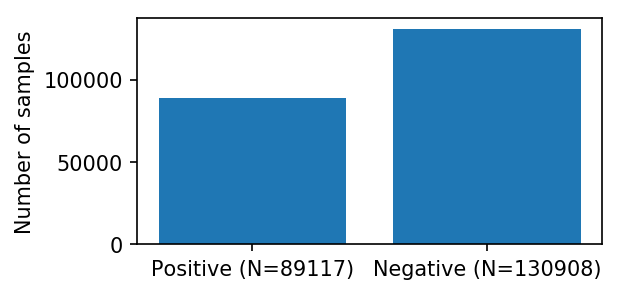

In [0]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(data['label']==0).sum(), (data['label']==1).sum()]); 
plt.xticks([1,0],["Negative (N={})".format((data['label']==0).sum()),"Positive (N={})".format((data['label']==1).sum())]);
plt.ylabel("Number of samples")

The distribution is approximately 60/40 negative to positive samples in the data. Hence, a trivial classifier, that just labels every sample as negative woud achieve an accuracy of 60%.


In [0]:
All = data.shape[0]
positive_samples = data[data['label'] == 1]
negative_samples = data[data['label'] == 0]

x = len(positive_samples)/All
y = len(negative_samples)/All

print('positive_samples:',x*100,'%')
print('negative_samples:',y*100,'%')

positive_samples: 40.503124644926714 %
negative_samples: 59.496875355073286 %


***

## Data visualization
<a id="visualization"></a>

__Plot some images with and without cancer tissue for comparison:__

In [0]:
def readImage(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img



Text(0, 0.5, 'Tumor tissue samples')

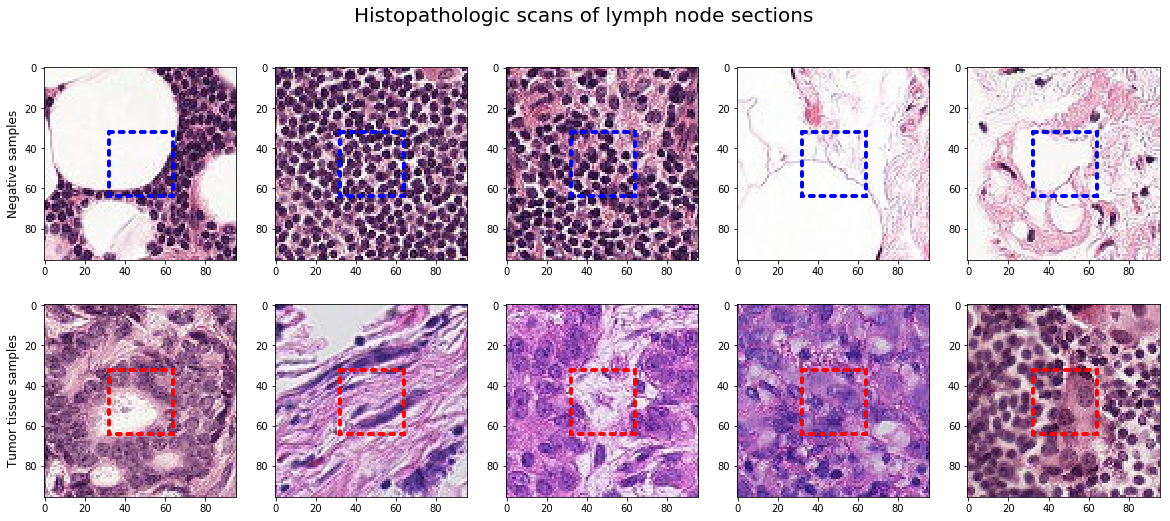

In [0]:
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections', fontsize=20)

#visualize negative samples 
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):

    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    
    box = patches.Rectangle((32,32), 32,32,linewidth=4, edgecolor='b',facecolor='none', linestyle=':',capstyle='round')
    ax[0,i].add_patch(box)
    
ax[0,0].set_ylabel('Negative samples', size='large')
    
#visualize positive samples
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
    
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

***

## Preprocessing the data and augmentation
<a id="preprocessing"></a>

At first I check, if there are missing values in the dataset. 

In [0]:
data.isnull().any().sum()

0

Obviously there are no missing values in the dataset.

The label of the image is only influenced by the center region (32x32px). Thus, the first idea is to crop data to that region. The information in the outer region could be useful. To figure out if this hypothesis is true, I train models with varying crop sizes and compair their performance. 

__Results:__ 

- Performance with 32x32px size is worse than with 90x90px. 


The augmentation we can use for this type of data: 

- random rotation 
- random crop 
- random flip (horizontal and vertical)
- random lightning 
- random zoom (not implemented here)
- Gaussioan blur (not implemented here)

In [0]:
import random 
ORIGINAL_SIZE = 96

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

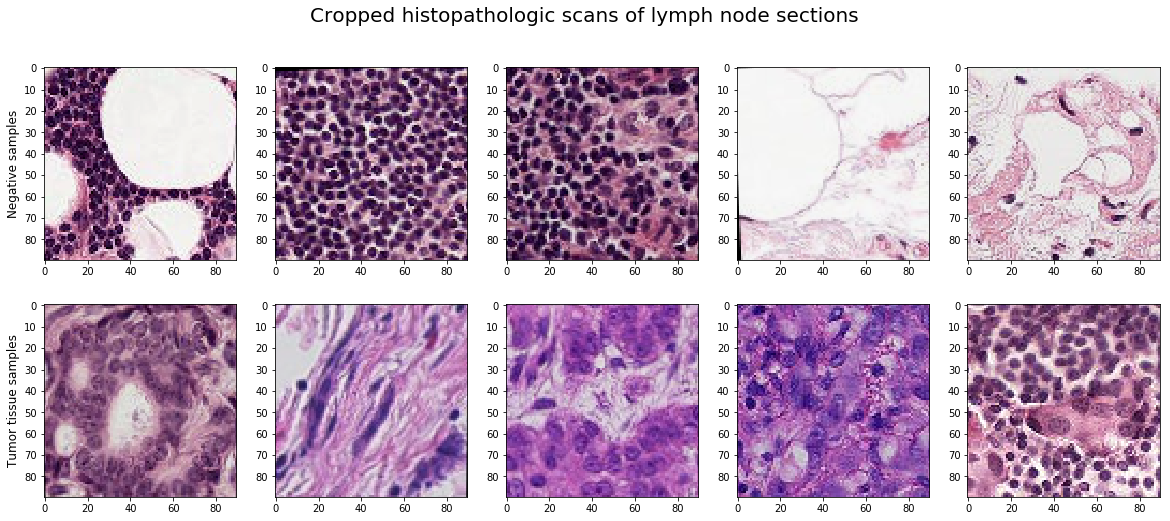

In [0]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections', fontsize=20)

#Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

__To see the effects of augmentation, I plot one image multiple times:__

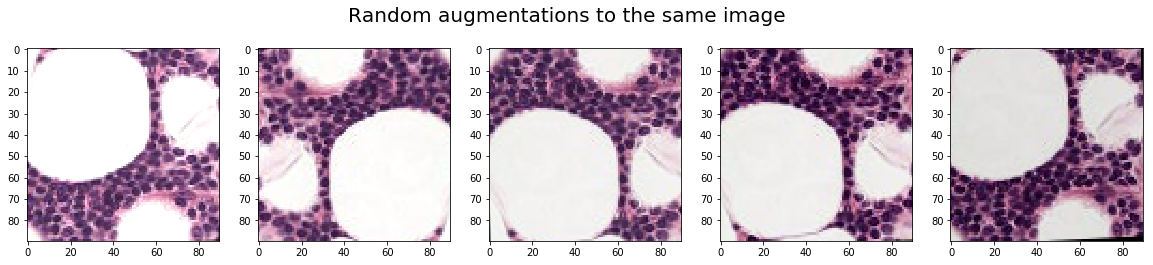

In [0]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random augmentations to the same image', fontsize=20)

#Negatives 
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path + '.tif'))

Here the image training set statisics are determined, to normalize the images in the `DataBunch`. 

At this step I also check if there exist completely white or black images exist in the dataset. These outliers can be deleted before training. Otherwise they would be recognized by the model as bening tissue (label 0) because they are annotated as negative sample.

The relevant data are color images and color images are described by pixels. Every pixel is represented by three 8 bit numbers associated to the colors red, green and blue (RGB-image). If all three channels are at full intensity its value is 255, which shows as white color. If all three colors are muted, or have the value 0 it results black color. 

In [0]:
dark_th = 10 / 255      # If no pixel reaches this threshold, image is considered too dark
bright_th = 245 / 255   # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0
for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'):
    path = os.path.join(train_path, idx)
    imagearray = readCroppedImage(path + '.tif', augmentations = False).reshape(-1,3)
    # is this too dark
    if(imagearray.max() < dark_th):
        too_dark_idx.append(idx)
        continue # do not include in statistics
    # is this too bright
    if(imagearray.min() > bright_th):
        too_bright_idx.append(idx)
        continue # do not include in statistics
    x_tot += imagearray.mean(axis=0)
    x2_tot += (imagearray**2).mean(axis=0)
    counted_ones += 1
    
channel_avr = x_tot/counted_ones
channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2)
channel_avr,channel_std

(array([0.70244707, 0.54624322, 0.69645334]),
 array([0.23889325, 0.28209431, 0.21625058]))

In [0]:
print('There was {0} extremely dark image'.format(len(too_dark_idx)))
print('and {0} extremely bright images'.format(len(too_bright_idx)))
print('Dark one:')
print(too_dark_idx)
print('Bright ones:')
print(too_bright_idx)

There was 1 extremely dark image
and 6 extremely bright images
Dark one:
['9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
Bright ones:
['9071b424ec2e84deeb59b54d2450a6d0172cf701', '5f30d325d895d873d3e72a82ffc0101c45cba4a8', 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b', '54df3640d17119486e5c5f98019d2a92736feabc', 'c448cd6574108cf14514ad5bc27c0b2c97fc1a83', '5a268c0241b8510465cb002c4452d63fec71028a']


__Plot some of the very bright or very dark images__

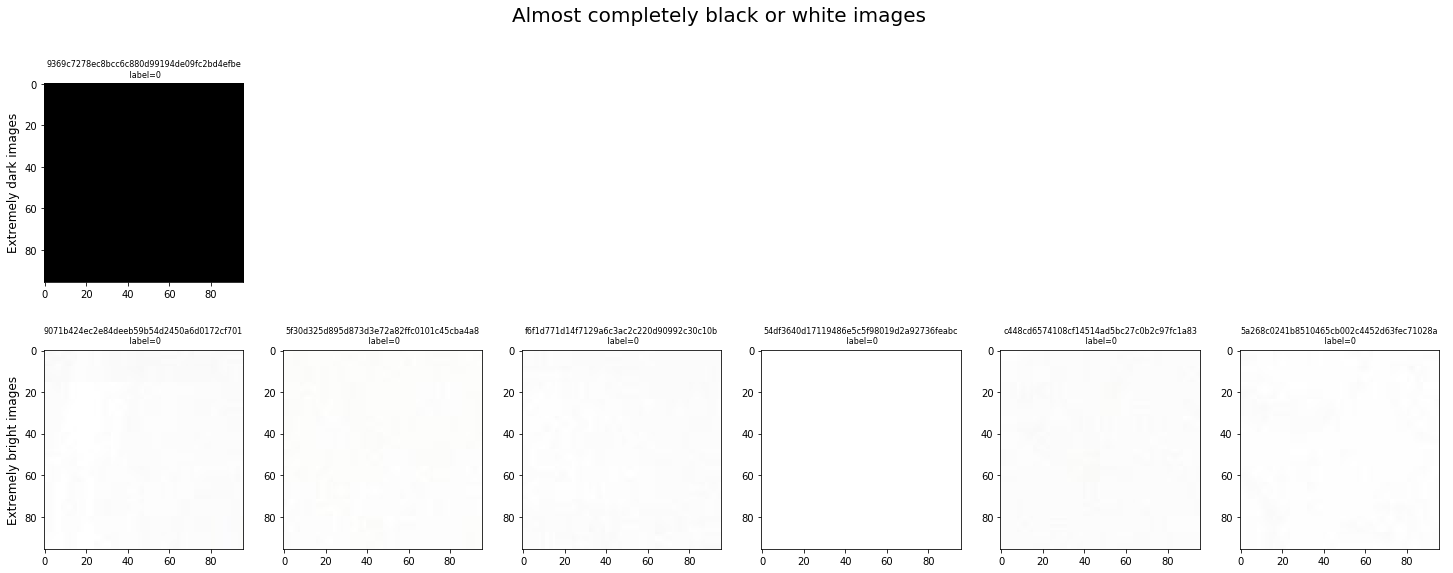

In [0]:
fig, ax = plt.subplots(2,6, figsize=(25,9))
fig.suptitle('Almost completely black or white images',fontsize=20)
# Too dark
i = 0
for idx in np.asarray(too_dark_idx)[:min(6, len(too_dark_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[0,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[0,0].set_ylabel('Extremely dark images', size='large')
for j in range(min(6, len(too_dark_idx)), 6):
    ax[0,j].axis('off') # hide axes if there are less than 6
# Too bright
i = 0
for idx in np.asarray(too_bright_idx)[:min(6, len(too_bright_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[1,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[1,0].set_ylabel('Extremely bright images', size='large')
for j in range(min(6, len(too_bright_idx)), 6):
    ax[1,j].axis('off') # hide axes if there are less than 6


***

## Baseline Model 
<a id="model"></a>

### Preparing the data
<a id="preparing"></a>

Before setting up the model it is important to split the available data in different sets (train, validation and test set) to be able to evaluate the model. Simple hold-out validation is implemented to prevent overfitting. Overfitting can occur while training the model on a training set and the model is fit too much on the training data. Thus, predictions on data that was not trained on failed or get worse. ([Francois Chollet, Deep learning with Python](https://proquest.safaribooksonline.com/book/programming/python/9781617294433/part-2dot-deep-learning-in-practice/kindle_split_015_html#X2ludGVybmFsX0h0bWxWaWV3P3htbGlkPTk3ODE2MTcyOTQ0MzMlMkZraW5kbGVfc3BsaXRfMDEzX2h0bWwmcXVlcnk9))

Here I split the training set into 90% training data and 10% validation data in stratified fashion. This means the data is split up in a class balanced way. The parameter `stratify` divides the dataset in  a way that the proportion of values provided to the parameter euqal the proportion of values of the splitted sample. It can be used here, beause the distribution of binary categorial variables is almost balanced with a 60/40 ratio.


`random_state` is implemented to receive the same output on different executions (runs). Otherwise with each execution a new random value would be generated and the train and test datasets would contain different values.

In [0]:
from sklearn.model_selection import train_test_split

train_df = data.set_index('id')

# To remove outliers, uncomment the four lines below
print('Before removing outliers we had {0} training samples.'.format(train_df.shape[0]))
train_df = train_df.drop(labels=too_dark_idx, axis=0)
train_df = train_df.drop(labels=too_bright_idx, axis=0)
print('After removing outliers we have {0} training samples.'.format(train_df.shape[0]))

train_names = train_df.index.values
train_labels = np.asarray(train_df['label'].values)

tr_n, tr_idx, val_n, val_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1, stratify=train_labels, random_state=123)

Before removing outliers we had 220025 training samples.
After removing outliers we have 220018 training samples.


### Model architecture
<a id="architecture"></a>

I use the pre-trained model ResNet from PyTorch library for transfer learning. At first I load the relevant modules  and then specify the model architecture, batch-size, input size and define a model path. The model path will extract the model architecture name as model file name. Then I create a data frame for the fast.ai loader. Afterwards, the `imgDataBunch`  is set up.


__In the next code cell model architecture is specified. To try different model architectures, the parameter `arch` has to be changed!__

In [0]:
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

arch = resnet101                    # specify model architecture 
BATCH_SIZE = 128                    # specify batch size
sz = CROP_SIZE                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet101'

In [0]:
# create dataframe for the fastai loader
train_dict = {'name': train_path + train_names, 'label': train_labels}
df = pd.DataFrame(data=train_dict)
# create test dataframe
test_names = []
for f in os.listdir(test_path):
    test_names.append(test_path + f)
df_test = pd.DataFrame(np.asarray(test_names), columns=['name'])



In [0]:
# Subclass ImageList to use our own image opening function
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = readCroppedImage(fn.replace('//./',''))
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32))

The `imgDataBunch` defines:
* How data is split in train and validation test set.
* Where the labels are.
* Is there a dataframe pointing to the test set.
* Which transformations to do. (As custom transformations are implemented in the image loader, there is no need to apply transformations here)
* How large is batchsize of a databunch.
* Normalization with training set statistics.


In [0]:
imgDataBunch = (MyImageItemList.from_df(path='/', df=df, suffix='.tif')
        .split_by_idx(val_idx)
        .label_from_df(cols='label')
        .add_test(MyImageItemList.from_df(path='/', df=df_test))
        .transform(tfms=[[],[]], size=sz)
        .databunch(bs=BATCH_SIZE)
        .normalize([tensor([0.702447, 0.546243, 0.696453]), tensor([0.238893, 0.282094, 0.216251])])
       )

After data is properly set up in a `DataBunch`, it is useful to see what a sample of a batch looks like:

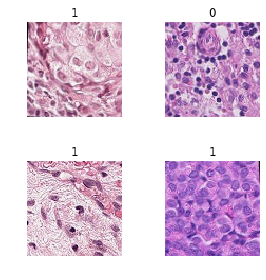

In [0]:
imgDataBunch.show_batch(rows=2,figsize=(4,4))

---

## Training
<a id="training"></a>


Once data is set up in a `DataBunch`, I create a CNN learner object to train the classifier:

- ps = dropout percentage (0-1) in the final layer; added to regularize the model (avoiding overfitting)
- opt_func = Adam Optimizer
- metrics = accuracy 
- wd = weight decay, is the L2 penalty of the optimizer (set by grid search with 1e-2, 1e-4 and 1e-6 weight decays)
- .to_fp_16 = Mixed precision training that allows forward and backward passes of the network to be done in fp16. It can accelerate training and improve accuracy. (Here this option is deactivted despite its positive effects because visualization of the network with Grad-CAM does not work with this option.)

In [0]:
def getLearner():
    return cnn_learner(
        imgDataBunch,
        arch,
        pretrained=True,
        path='.',
        metrics=accuracy,
        ps=0.5,
        callback_fns=ShowGraph
    )#.to_fp16

learner = getLearner()

In [0]:
learner.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (198016 items)
x: MyImageItemList
Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90)
y: CategoryList
1,0,0,0,1
Path: /;

Valid: LabelList (22002 items)
x: MyImageItemList
Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90)
y: CategoryList
1,0,1,1,0
Path: /;

Test: LabelList (57458 items)
x: MyImageItemList
Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90),Image (3, 90, 90)
y: EmptyLabelList
,,,,
Path: /, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), 

To see how `learner` object is set up, `learner.summary` or `learner.model` reveal the architecture structure and hyper-parameter settings which are partially set by default (e.g loss function, optimization function)

In [0]:
len(learner.model)

2

In [0]:
type(learner.model)

torch.nn.modules.container.Sequential

### 1cycle policy
<a id="1cycle"></a>

To select the hyper-parameters weight decay and learning rate, I use 1cycle policy proposed by [Leslie Smith 2018](https://arxiv.org/abs/1803.09820). This apporach is supported by fast.ai library, which implemented a training function for 1cycle policy.

First, I determine optimal learning rate and weight decay values with a small grid search with 1e-2, 1e-4 and 1e-6 weight decays. `lr_find` can be used with different weight decays, thus all losses are recorded and plotted on the same graph.


In [0]:
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-8
learner.lr_find(wd=1e-8, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-8')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


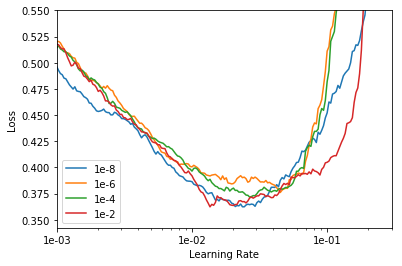

In [0]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

__Weight decay selection:__

Generally, I select the largest weight decay that achieves a low loss and has the highest learning rate before its loss increases rapidly. The plotted weight decays can differ between runs because the algorithm chooses a random subset of the data for computations. 

For example the following figure shows an output of weight decay grid search: Out of the tested weight decays, I choose the largest weight decay  (1e-4) that allows training with a maximal learning rate (2e-2). Learning rate is selected at the point close to the minima, where loss is still descending (Red point).

![alt](https://raw.githubusercontent.com/myrmsch/Image_Learning_Medical_Image_Classification/master/sample_images/Weight%20Decay%20-%20Learning%20rate%20vs.%20Loss%20.png)



### Training Phase 1 

Firstly, I train the head of the model  for eight epochs while keeping the rest of the model frozen. 

Depending on the hyperparameter setting of learning rate and weight decay, the parameter of the head of the network are adjusted. To determine, if the model works correctly, I follow a rule of thumbs:

* __Learning rate setting:__ 
    *  Learning rate too high: Usually, validation loss is smaller than 1. If validation loss gets very high, I train the model again with a lower learning rate.
    * Learning rate too low: The accuracy should descent steadily, if that is not the case, learning rate is too low. If after adjusting higher learning rates, validation loss increases rapidly, than I decrease the learning rate again and try to train for more epochs.

* __Epochs:__ 
    * In the case, that the plotted loss is increasing after training many epochs, I repeat training with fewer epochs. I select the number of epochs, where the loss is minimal.
    * If validation loss and training loss diverge, it is a sign to stop training because the model is overfitting.
    
The findings reviewed in the belonging script result from the following experimental settings:
    

__Training Phase 1 - Baseline model hyper-parameter setting:__    

 Hyper-Parameter setting  | ResNet 50 | ResNet 101 | DenseNet 169 | DenseNet 161
  ------------- | ------------- | -------------  | -------------  | -------------
  Weight Decay | 1e-2 | 1e-4 | 1e-6 | 1e-6
  Learning Rate  | 1e-2 | 2e-2 | 2e-2 | 1e-2
  Number of Epochs | 8 | 8 | 8 | 8

epoch,train_loss,valid_loss,accuracy,time
0,0.223638,0.309966,0.886329,04:31
1,0.218739,0.320057,0.884965,04:31
2,0.190577,0.194084,0.924371,04:32
3,0.168503,0.180233,0.935324,04:32
4,0.168468,0.149297,0.945141,04:32
5,0.147945,0.150019,0.945050,04:33
6,0.118697,0.123198,0.956958,04:32
7,0.139231,0.118895,0.957867,04:33


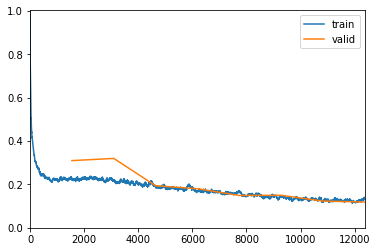

In [0]:
max_lr = 2e-2
wd = 1e-4

learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

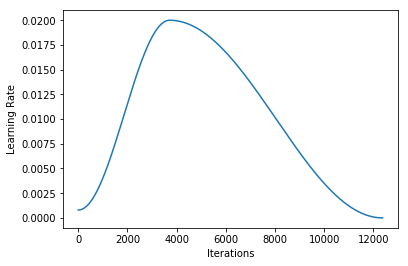

In [0]:
# plot learning rate of the one cycle
learner.recorder.plot_lr()

__Learning rate of the one cycle:__ The plot depicted above shows the learning rate of one cycle. In this case the cycle has a length of eight epochs. The learning rate starts in the beginning with a very low value and reachtes the maximum learning rate (the selected learning rate) in the middle. Afterward it slows back down. 

The idea behind this cycle is that if learning rate is kept the same, it could stay in a local minima and does not reach the global minima. With gradually  increasing learning rates will jumps out of local minima and generalize better.We can see that the learning rate starts from lower and reaches the max_lr in the middle. Then it slows back down near the end. The idea is that we start with a low warm-up learning rate and gradually increase it to high. The higher rate is having a regularizing effect as it won't allow the model to settle for sharp and narrow local minima but pushes for wider and more stable one.

In the middle of our cycle, we start to lower the learning rate as we are hopefully in a good stable area. This means that we start to look for the minima within that area.

### Analysing first results
<a id="analyse"></a>


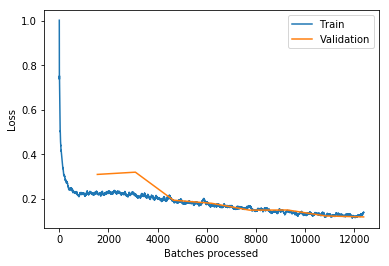

In [0]:
# and plot the losses of the first cycle
learner.recorder.plot_losses()

The plot of losses shows a small rise after the initial drop. This is caused by the increasing learning rate of the first half cycle. The losses are temporarily rising while max_lr drives the model out of local minima.

#### Predictions on a sample of the validation set
<a id="pred"></a>

The model has quickly reached around 95% accuracy. Thus, it is a good point to see its predictions on a sample of the validation set. 

There are various alternatives to do so:
* Prediction of a single image from the trained learner
* Confusion matrix
* `show_results` method
* Plotting top losses


##### Predicitions of a single sample image
<a id="predimg"></a>

`predict` can be used to get a single prediction from the trained learner on one specific sample image.

In [0]:
learner.data.train_ds[0]

(Image (3, 90, 90), Category 1)

The dataset consists of tuples, where the first element is the data itself. The second element is the target label.

In [0]:
data = learner.data.train_ds[0][0]

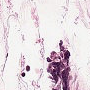

In [0]:
data

In [0]:
pred = learner.predict(data)
pred

(Category 0, tensor(0), tensor([0.9179, 0.0821]))

The first two elements of the tuple are, respectively, the predicted class and label. The last element is the predicted probabilities

***

##### Confusion matrix
<a id="confusion"></a>

The confusion matrix plots the counts of actual vs. predicted labels and shows the model's performance in a simple table. With the confusion matrix it becomes clear how the fasle negative and positives are distributed. Once the model has learned to distinguish tumor and normal samples it is performing relatively well and is ready for further training.

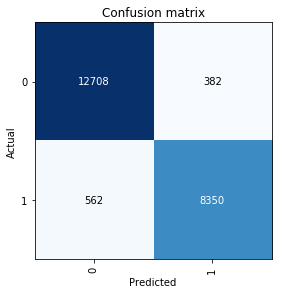

In [0]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

***

##### Plotting top losses
<a id="toplosses"></a>

In [0]:
# modified version of fastai's plot_top_losses (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L114)
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

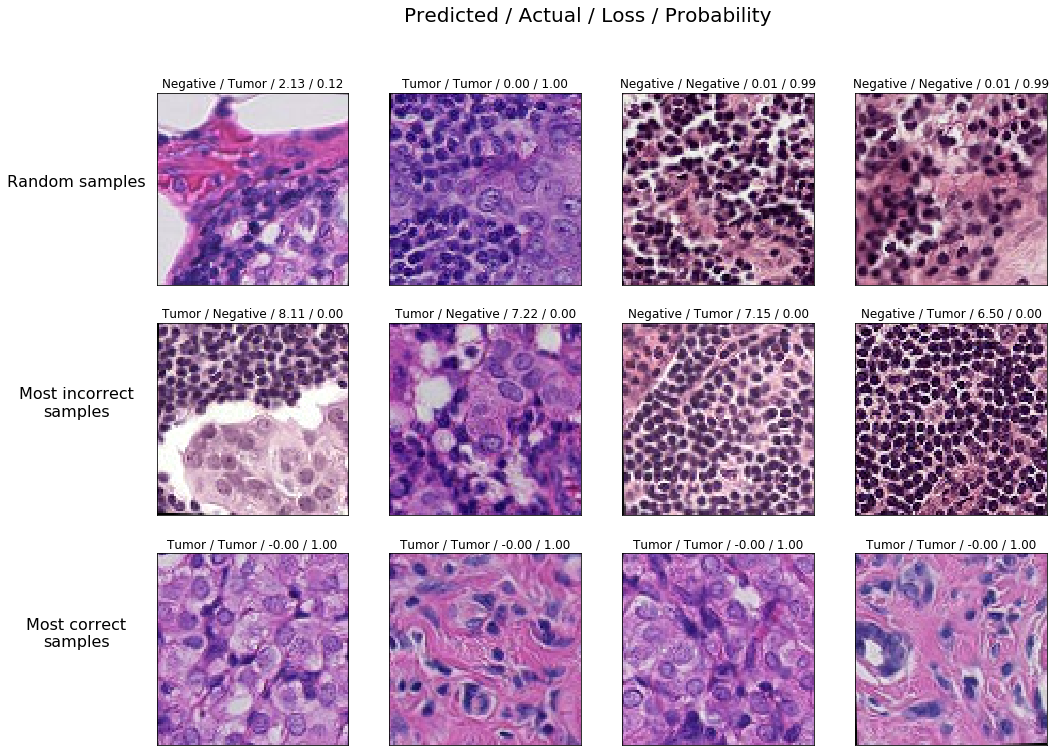

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
plot_overview(interp, ['Negative','Tumor'])

***

##### `show_results` method
<a id="results"></a>

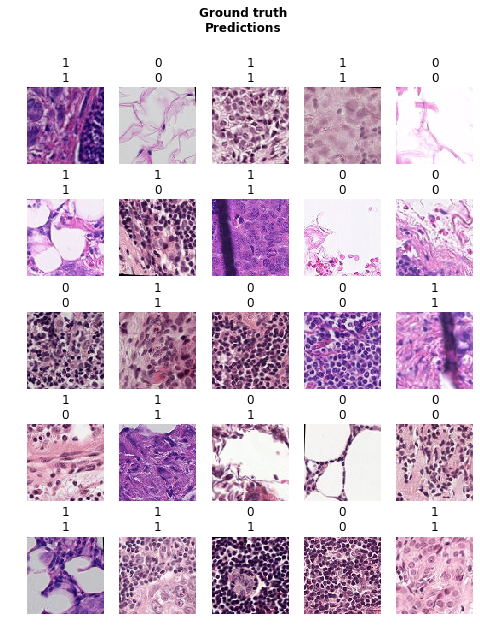

In [0]:
learner.show_results(figsize=(8,10))

Before finetuning the baseline model, I save the model at this stage. This simpifies handling worse performance results after finetuning.

In [0]:
learner.save(MODEL_PATH + '_stage1')

---

## Fine-tuning the baseline model
<a id="finetuning"></a>

In the next step,  I unfreeze all the trainable parameters from the model and continue its training. In this training phase with unfrozen layers, I apply the same rules for hyper-parameter setting as in training stage 1.




LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


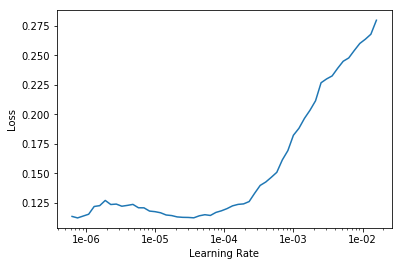

In [0]:
learner.load(MODEL_PATH + '_stage1')


learner.unfreeze()
learner.lr_find(wd=wd)


learner.recorder.plot()

### Training Phase 2

In training phase two, where all trainable parameters are unfrozen, I select a smaller learning rate and define the minimum and maximum learning rate of the cycle.

The findings reviewed in the belonging script result from the following experimental settings:

__Training Stage 2 - Fine-Tuning hyper-parameter setting:__

 Hyper-Parameter setting  | ResNet 50 | ResNet 101 | DenseNet 169 | DenseNet 161
  ------------- | ------------- | -------------  | -------------  | -------------
  Learning Rate  | 4e-5, 4e-4 | 1e-5, 1e-4 | 4e-5, 4e-4  | 1e-5, 1e-4 |
  Number of Epochs | 20 | 12 | 22 | 12
  
  

  



epoch,train_loss,valid_loss,accuracy,time
0,0.127398,0.120010,0.956322,06:01
1,0.119732,0.115598,0.959367,06:03
2,0.122168,0.119046,0.956686,06:05
3,0.119250,0.116915,0.958640,06:05
4,0.113993,0.113316,0.959367,06:04
5,0.104934,0.110800,0.960322,06:04
6,0.117065,0.110534,0.960913,06:04
7,0.103697,0.105318,0.962503,06:04
8,0.103428,0.104867,0.962776,06:04
9,0.098789,0.103228,0.963276,06:04


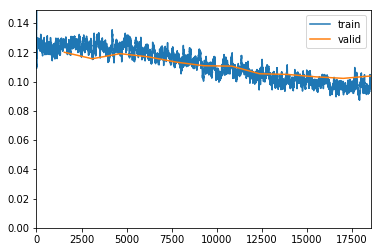

In [0]:
learner.fit_one_cycle(cyc_len=12, max_lr=slice(2e-6,2e-5))

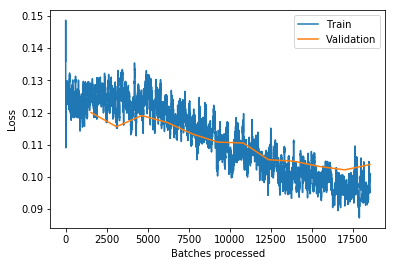

In [0]:
learner.recorder.plot_losses()

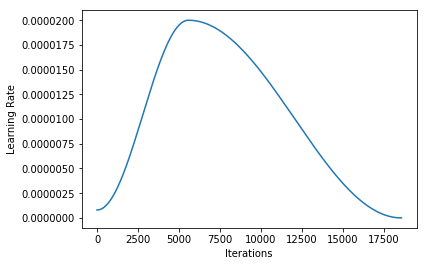

In [0]:
learner.recorder.plot_lr()

__First analyse of results with confusion matrix:__

A second look at the confusion matrix after fine-tuning reveals if the model has improved. If it has improved I save the fine-tuned model.

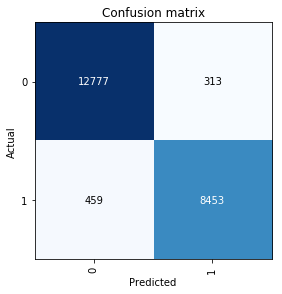

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [0]:
learner.save(MODEL_PATH + '_stage2')

In [0]:
# if the model was better before fine-tuning, uncomment this to load the previous stage
#learner.load(MODEL_PATH + '_stage1')


---

## Validation and analysis
<a id="validation"></a>

Now the training is done.

### Model performance
<a id="performance"></a>

We can only get metrics from our validation set, and the final test metrics will be most likely a bit different.

In [0]:
preds,y, loss = learner.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0}.'.format(acc))

The accuracy is 0.9645487070083618.


  __Validation Results of different architectures:__
  
CNN architecture | Validation accuracy |
  ------------- | ------------- 
  ResNet 50 | 0.9750
  ResNet 101 | 0.9694
  DenseNet 161 | 0.9700
  DenseNet 169 | 0.9711
  

### Model performance in terms of project requirements
<a id="requirements"></a>

It is a good idea to look at examples of images from:

- Random samples (some random predictions)
- The most incorrectly labeled (what our model predicts wrong with very high probability)
- The most correctly labeled (what our model is most confident of and gets right)
    
This visualization helps to understand what images the model struggles with. It might also reveal something about the dataset, such as bad quality data.

In [0]:
# modified fastai's plot_top_losses (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L114)
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

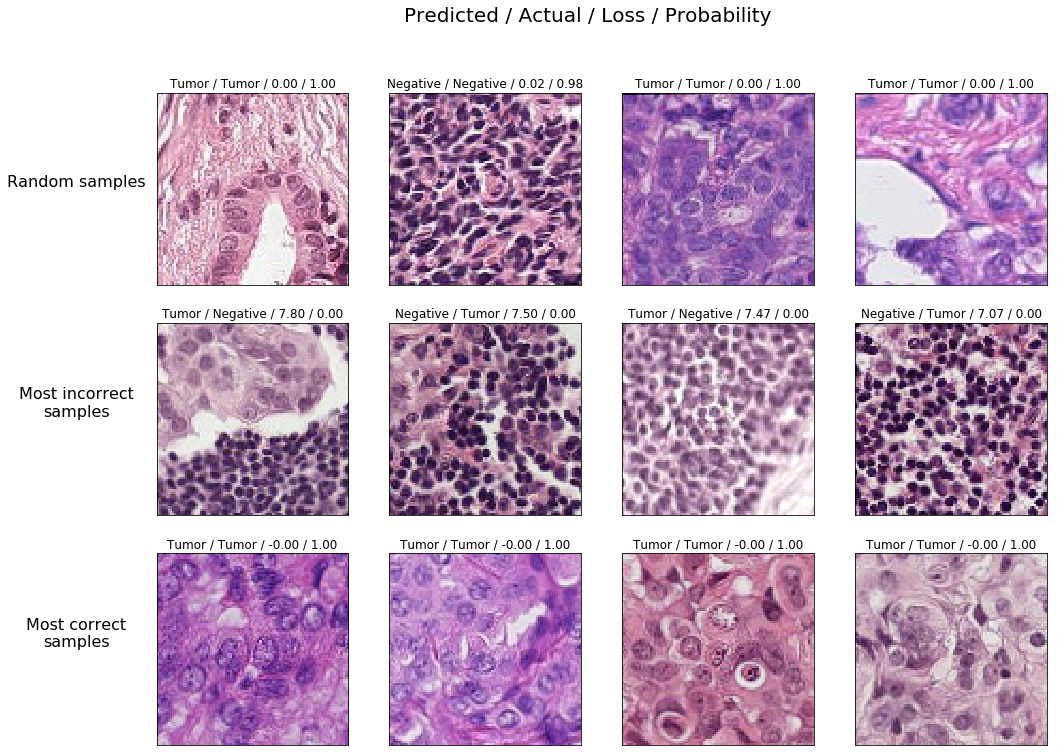

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
plot_overview(interp, ['Negative','Tumor'])

### Gradient-weighted Class Activation Mapping (Grad-CAM)
<a id="gradcam"></a>

Grad-CAM provides visual explanations from CNN via gradient-based localization and gives transparency to the model's decision making. This method produces a localization map highlighting the areas that the model considers important for the classification decision. Vizualizing the processes within a neuronal network can reveal data  inconsistencies  or bad data quality.



In [0]:
from fastai.callbacks.hooks import *

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

In [0]:
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

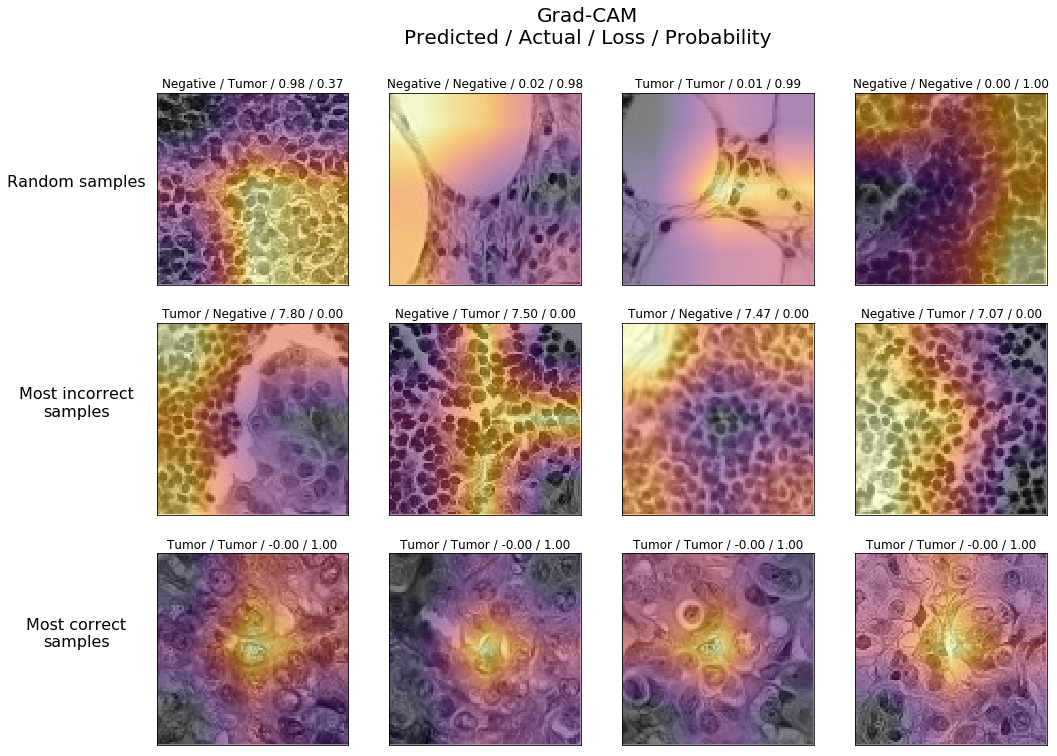

In [0]:
plot_heatmap_overview(interp, ['Negative','Tumor'])

This shows the activation maps of the predicted category so if the label is tumor, the visualization shows all the places where the model thinks the tumor patterns are. Looking at the most correct samples visualized, it becomes obvious that the model learned to localize tumor pattern in the center (32x32px) of the image. 

### ROC and AUC
<a id="rocauc"></a>

***Receiver Operator Characteristic (ROC):*** The ROC-Curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system. It plots the true positive rate (TPR) against the false positive rate (FPR).

***Area Under the Curve (AUC):*** The AUC measures the area under the ROC curve and ranges in value from 0 to 1. It provides an aggregate measure of performance across all possible classification thresholds.


These metrics are used to compute the competition score in Kaggle. BUT: The ROC area computed in the following can differ to the results of the submission. This occurs as here ROC area is computed with validation set and Kaggle uses the test set.

In [0]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('Area under ROC is {0}'.format(roc_auc))

ROC area is 0.9927437345102885


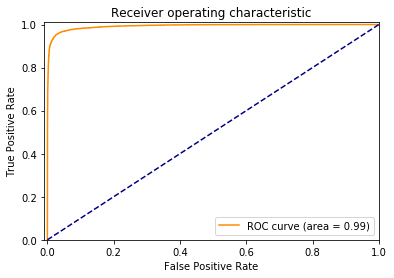

In [0]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

---

## Submit predictions
<a id="submit"></a>

### TTA
<a id="tta"></a>

After training the model I use Test Time Augmentation (TTA) to further increase accuracy of the model. TTA takes random samples with and without data augmentation, calculates the predictions, and takes the average to make the final prediction. 

In [0]:
learner.load(MODEL_PATH + '_stage2')

# Fastai has a function for this but additional augmentations is not wanted because the image loader does augmentations 
#preds_test,y_test=learner.TTA(ds_type=DatasetType.Test)

n_aug = 12
preds_n_avg = np.zeros((len(learner.data.test_ds.items),2))
for n in tqdm_notebook(range(n_aug), 'Running TTA...'):
    preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)
    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
preds_n_avg = preds_n_avg / n_aug

In [0]:
# transform class probabilities to tumor class probabilities
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0]))
tumor_preds = preds_n_avg[:, 1]
print('Tumor probability: ' + str(tumor_preds[0]))
# get class predictions
class_preds = np.argmax(preds_n_avg, axis=1)
classes = ['Negative','Tumor']
print('Class prediction: ' + classes[class_preds[0]])

Negative and Tumor Probabilities: [9.997789e-01 2.210979e-04]
Tumor probability: 0.00022109791098046117
Class prediction: Negative


### Submit the model for evaluation
<a id="evaluation"></a>



In [0]:
!pwd


/media/data/colab


In [0]:
SAMPLE_SUB = 'sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)

# List of tumor preds. 
# These are in the order of the test dataset and not necessarily in the same order as in sample_submission
pred_list = [p for p in tumor_preds]

# Create a dict of id:pred
pred_dic = dict((key, value) for (key, value) in zip(learner.data.test_ds.items, pred_list))

# Create a new list with the same order as in sample_submission
pred_list_cor = [pred_dic['//./test/' + id + '.tif'] for id in sample_list]

# Next, a Pandas dataframe with id and label columns.
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})

# Export to csv
df_sub.to_csv('{0}_submission.csv'.format(MODEL_PATH), header=True, index=False)

In [0]:
df_sub.head(10)

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.014141
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.091409
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.003386
3,2c35657e312966e9294eac6841726ff3a748febf,0.003764
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.002352
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0.998928
6,aa0307865281d4484ddf8c637c348292968b93a7,0.116242
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0.157668
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0.003777
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0.008017


In [0]:
!kaggle competitions submit -c histopathologic-cancer-detection -f resnet101_submission.csv -m "Testdurchlauf"

100%|██████████████████████████████████████| 3.36M/3.36M [00:02<00:00, 1.19MB/s]
Successfully submitted to Histopathologic Cancer Detection

---


## Deployment
<a id="deployment"></a>
A trained and working model can be deployed for inference to another machine, such as a web app or server. Therefore, the next code cell creates an export.pkl file, which saves the internal information needed for inference.



In [0]:
learner.export('./export.pkl')